In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table as Table
import matplotlib.pyplot as plt
from linetools.spectra import utils as ltsu
from linetools.spectra.xspectrum1d import XSpectrum1D
import astropy.units as u
from astropy import constants as const
from numpy import random as ran
%matplotlib inline

# An old routine that illustrates the value in stacking more

In [ ]:
#the 2016 survey

#to order and match the spec with their z values
spec_atr_16 = Table.read('/home/jsm/Research/2018-2019/Spectra/old_spec/spec_atr.txt', format = 'ascii') 

#an initial filter to ensure the spec included cover lya
basestring_16 = '/home/jsm/Research/2018-2019/Spectra/old_spec/'

init_spec_16 = []

init_z_16 = []
    
for entry in spec_atr_16:
    
    if 2.0 < entry["zspec"] < 2.5: #the redshift bin
        
        temp = XSpectrum1D.from_file(basestring_16 + entry["Filename"])
        
        if temp.wvmin < (1216*u.AA)*(1+entry["zspec"]) < temp.wvmax:
                
            init_z_16.append(entry["zspec"])
                
            init_spec_16.append(XSpectrum1D.from_file(basestring_16 + entry["Filename"]))

In [ ]:
#the 2017 survey

#to order and match the spec with their z values
spec_atr_17 = Table.read('/home/jsm/Research/2018-2019/Spectra/new_spec/cl2017_redux/cl2017_valueadded_release_20171009.txt',
                         format = 'ascii') 

#an initial filter to ensure the spec included cover lya
basestring_17 = '/home/jsm/Research/2018-2019/Spectra/new_spec/cl2017_redux/spec_v0/'

init_spec_17 = []

init_z_17 = []
    
for entry in spec_atr_17:
    
    if 2.0 < entry["col5"] < 2.5: #the redshift bin
        
        temp = XSpectrum1D.from_file(basestring_17 + entry["col1"])
        
        if temp.wvmin < (1216*u.AA)*(1+entry["col5"]) < temp.wvmax:
                
            init_z_17.append(entry["col5"])
                
            init_spec_17.append(XSpectrum1D.from_file(basestring_17 + entry["col1"]))

In [ ]:
spec = np.asarray(init_spec_16 + init_spec_17)

print("Number of spectra (Nspec) after filter =", len(spec))

red = np.asarray(init_z_16 + init_z_17)

In [ ]:
# the normalization

r_2  = range(len(spec))

temp_2 = [np.asarray(spec[i].wavelength/(1+red[i])) for i in r_2]

wv_norm_1 = [ (1270 < entry) & (entry < 1300) for entry in temp_2 ]

wv_norm_2 = [ (1308 < entry) & (entry < 1330) for entry in temp_2 ]

wv_norm_3 = [ (1340 < entry) & (entry < 1390) for entry in temp_2 ]

wv_norm_4 = [ (1410 < entry) & (entry < 1450) for entry in temp_2 ]


In [ ]:
wv_norm = []

for i in range(len(temp_2)):
    
    wv_norm.append(wv_norm_1[i] | wv_norm_2[i] | wv_norm_3[i] | wv_norm_4[i])

In [ ]:
stiched_range = np.asarray([spec[i].flux[wv_norm[i]] for i in r_2])   

medians = np.asarray([np.median(stiched_range[i]) for i in r_2])

norm_flux = np.asarray([(spec[i].flux/medians[i]) for i in r_2])

In [ ]:
#the new scaled Xspec objects

scaled_spec = []

for i in r_2:       
    
    scaled_spec.append(XSpectrum1D(spec[i].wavelength,norm_flux[i],sig=spec[i].sig))

In [ ]:
bad_ind = [1,6,14,17,24,25,27,29,33,34,37,39,41,42,46,47,51,59,65,71,87,92,97,101,104,
        105,113,115,118,121,126,136,142,147,149,151,159,161,169,177,207,212,222,238,264,266,278]

scaled_spec = np.delete(scaled_spec,bad_ind)

red = np.delete(red,bad_ind)

In [ ]:
#the first trim on the wavelegth array to ensure a solid stack [440:1500]

trim_spec = []

for i in range(len(scaled_spec)):       
    
    trim_spec.append(XSpectrum1D(scaled_spec[i].data["wave"][0][600:850],
                                scaled_spec[i].data["flux"][0][600:850],
                                scaled_spec[i].data["sig"][0][600:850]))
    
print("Number of spectra to be stacked =", len(trim_spec))

In [ ]:
collate_1 = ltsu.collate(trim_spec[125:130])

collate_2 = ltsu.collate(trim_spec[0:70])

collate_3 = ltsu.collate(trim_spec[0:130])

collate_4 = ltsu.collate(trim_spec)

In [ ]:
rest_spec_1 = ltsu.rebin_to_rest(collate_1, red[125:130], 150*u.km/u.s,grow_bad_sig = True)

rest_spec_2 = ltsu.rebin_to_rest(collate_2, red[0:70], 150*u.km/u.s,grow_bad_sig = True)

rest_spec_3 = ltsu.rebin_to_rest(collate_3, red[0:130], 150*u.km/u.s,grow_bad_sig = True)

rest_spec_4 = ltsu.rebin_to_rest(collate_4, red, 150*u.km/u.s,grow_bad_sig = True)

In [ ]:
stack_1 = ltsu.smash_spectra(rest_spec_1)

stack_2 = ltsu.smash_spectra(rest_spec_2)

stack_3 = ltsu.smash_spectra(rest_spec_3)

stack_4 = ltsu.smash_spectra(rest_spec_4)

In [ ]:
fig, ax = plt.subplots(figsize=(8,11))


plt.subplot(4, 1, 1)
plt.plot(stack_1.wavelength, stack_1.flux,label="5 stack",color="#bd0026")
plt.xlim(1050,1430)
plt.ylim(-1,3)
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(stack_2.wavelength, stack_2.flux,label="70 stack",color="#f03b20")
plt.xlim(1050,1430)
plt.ylim(-1,3)
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(stack_3.wavelength, stack_3.flux,label="130 stack",color="#fd8d3c")
plt.xlim(1050,1430)
plt.ylim(-1,3)
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(stack_4.wavelength, stack_4.flux,label="238 stack",color="#feb24c")
plt.xlim(1050,1430)
plt.ylim(-1,3)
plt.text(1260.42,.25,"$SiII$",fontsize=12,color="#4d4d4d")
plt.text(1303.1685,.25,"$SiII$",fontsize=12,color="#4d4d4d")
plt.text(1334.5323,.25,"$CII$",fontsize=12,color="#4d4d4d")
plt.text(1360,.25,"$SiIV$ doublet",fontsize=12,color="#4d4d4d")
plt.text(1219,1.6,"$Lyα$",fontsize=12,color="#4d4d4d")
plt.xlabel("Wavelength Å")
plt.legend()

plt.show()

fig.savefig("/home/jsm/my_lbg_da/lbg_da/summer_2018/figures/png/Stacking_effects.png",bbox_inches='tight')


# differences in the S/N cuts

In [2]:
stack1 = XSpectrum1D.from_file("/home/jsm/PycharmProjects/tau_eff/fits/s2n_tests/stack_1.fits")

stack2 = XSpectrum1D.from_file("/home/jsm/PycharmProjects/tau_eff/fits/s2n_tests/stack_2.fits")

stack3 = XSpectrum1D.from_file("/home/jsm/PycharmProjects/tau_eff/fits/s2n_tests/stack_3.fits")

stack4 = XSpectrum1D.from_file("/home/jsm/PycharmProjects/tau_eff/fits/s2n_tests/stack_4.fits")

stack5 = XSpectrum1D.from_file("/home/jsm/PycharmProjects/tau_eff/fits/s2n_tests/stack_5.fits")

[]

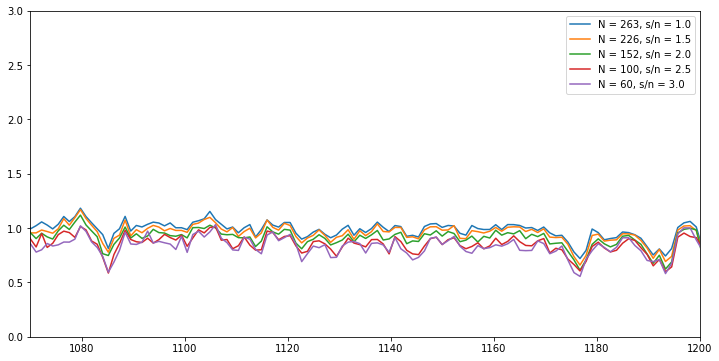

In [3]:
fig, ax = plt.subplots(figsize=(12,6))

plt.plot(stack1.wavelength,stack1.flux,label="N = 263, s/n = 1.0")
plt.plot(stack2.wavelength,stack2.flux,label="N = 226, s/n = 1.5")
plt.plot(stack3.wavelength,stack3.flux,label="N = 152, s/n = 2.0")
plt.plot(stack4.wavelength,stack4.flux,label="N = 100, s/n = 2.5")
plt.plot(stack5.wavelength,stack5.flux,label="N = 60, s/n = 3.0")

plt.xlim(1070,1200)
plt.ylim(0,3)
plt.legend()
plt.plot()

[]

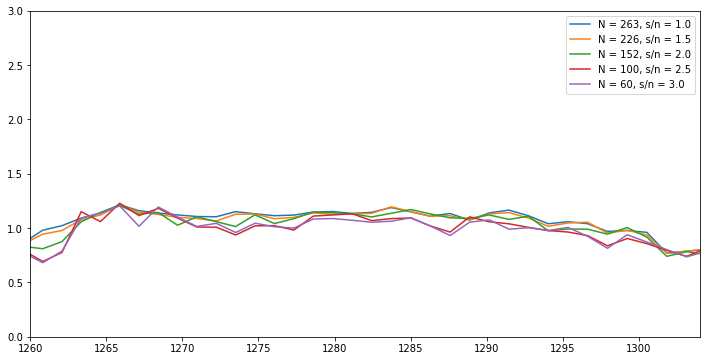

In [4]:
fig, ax = plt.subplots(figsize=(12,6))

plt.plot(stack1.wavelength,stack1.flux,label="N = 263, s/n = 1.0")
plt.plot(stack2.wavelength,stack2.flux,label="N = 226, s/n = 1.5")
plt.plot(stack3.wavelength,stack3.flux,label="N = 152, s/n = 2.0")
plt.plot(stack4.wavelength,stack4.flux,label="N = 100, s/n = 2.5")
plt.plot(stack5.wavelength,stack5.flux,label="N = 60, s/n = 3.0")

plt.xlim(1260,1304)
plt.ylim(0,3)
plt.legend()
plt.plot()